In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
gdf = gpd.read_file("points_with_samples.gpkg")
#gdf = gpd.read_file("points_with_samples_v1.1.gpkg")
#gdf = gpd.read_file("points_with_samples_training.gpkg")
gdf = gpd.read_file("points_with_samples_unet_2.0.4.gpkg")

gdf.head()

,OBJECTID_1,OBJECTID,stn_id,pnt_id,stn_pnt_id,veg_1980,veg_2007,veg_2018_a,conf1980,conf2007,...,bp2018_1,gradient_1,gradient_2,Forward,Backward,Stasis,meco2_name,meco2_date,lc_WV03_20190818_M1BS_1040010051771700-sr-02m,geometry
0,1,1,117408,28.0,117408_028,water,None,low shrub,high,None,...,no,1.061023,0.01061,0.894455,0.0,0.105545,low shrub,2019-06-28,1.0,POINT (100800 1467630)
1,2,2,117408,38.0,117408_038,water,None,low shrub,high,None,...,no,1.061023,0.01061,0.894455,0.0,0.105545,low shrub,2019-06-28,1.0,POINT (100830 1467630)
2,3,3,117408,49.0,117408_049,water,None,barren,high,None,...,no,1.061023,0.01061,0.894455,0.0,0.105545,barren,2019-06-28,1.0,POINT (100860 1467630)
3,4,4,117408,60.0,117408_060,barren,None,barren,high,None,...,no,1.061023,0.01061,0.894455,0.0,0.105545,barren,2019-06-28,1.0,POINT (100890 1467630)
4,5,5,117408,71.0,117408_071,barren,None,tall shrub,high,None,...,no,1.061023,0.01061,0.894455,0.0,0.105545,tall shrub,2019-06-28,1.0,POINT (100920 1467630)


In [3]:
gdf["meco2_name"].unique()

array(['low shrub', 'barren', 'tall shrub', 'water', 'other', 'spruce',
       'wet meadow', 'moist tundra', 'marsh'], dtype=object)

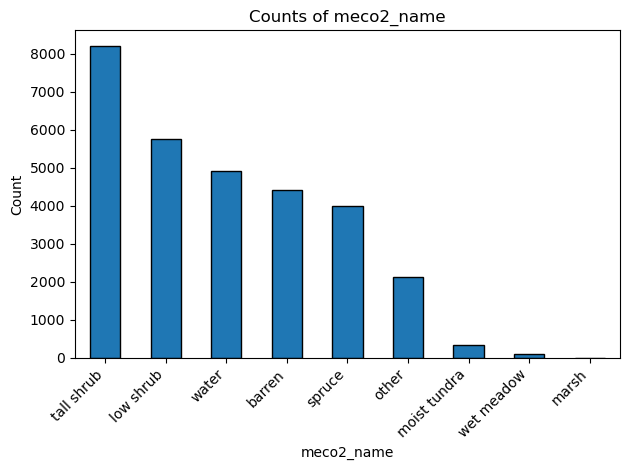

In [4]:
vc = gdf["meco2_name"].value_counts(dropna=False)  # include NaN as a bar
ax = vc.plot(kind="bar", edgecolor="black")
ax.set_xlabel("meco2_name")
ax.set_ylabel("Count")
ax.set_title("Counts of meco2_name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [5]:
# filter by year, add observation year
import re

# Make a dict mapping col → year
col_year = {}
for col in gdf.columns:
    if col.startswith("lc_"):
        m = re.search(r"(\d{8})", col)  # find YYYYMMDD
        if m:
            year = int(m.group(1)[:4])
            col_year[col] = year

# Suppose your reference year is in "meco2_date"
gdf["reference_year"] = gdf["meco2_date"].dt.year

# For each year, attach raster values from the same-year columns
for year in sorted(set(col_year.values())):
    # All raster cols for this year
    cols = [c for c,y in col_year.items() if y == year]
    if not cols:
        continue
    
    mask = gdf["reference_year"] == year
    if not mask.any():
        continue
    
    # Merge same-year rasters: take first non-null among them
    gdf.loc[mask, f"lc_val_{year}"] = (
        gdf.loc[mask, cols].bfill(axis=1).iloc[:, 0]
    )
gdf

,OBJECTID_1,OBJECTID,stn_id,pnt_id,stn_pnt_id,veg_1980,veg_2007,veg_2018_a,conf1980,conf2007,...,gradient_2,Forward,Backward,Stasis,meco2_name,meco2_date,lc_WV03_20190818_M1BS_1040010051771700-sr-02m,geometry,reference_year,lc_val_2019
0,1,1,117408,28.0,117408_028,water,None,low shrub,high,None,...,0.01061,0.894455,0.0,0.105545,low shrub,2019-06-28,1.0,POINT (100800 1467630),2019,1.0
1,2,2,117408,38.0,117408_038,water,None,low shrub,high,None,...,0.01061,0.894455,0.0,0.105545,low shrub,2019-06-28,1.0,POINT (100830 1467630),2019,1.0
2,3,3,117408,49.0,117408_049,water,None,barren,high,None,...,0.01061,0.894455,0.0,0.105545,barren,2019-06-28,1.0,POINT (100860 1467630),2019,1.0
3,4,4,117408,60.0,117408_060,barren,None,barren,high,None,...,0.01061,0.894455,0.0,0.105545,barren,2019-06-28,1.0,POINT (100890 1467630),2019,1.0
4,5,5,117408,71.0,117408_071,barren,None,tall shrub,high,None,...,0.01061,0.894455,0.0,0.105545,tall shrub,2019-06-28,1.0,POINT (100920 1467630),2019,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29828,29829,0,104305,0.0,None,low shrub,water,None,moderate,moderate,...,0.00000,0.000000,0.0,0.000000,water,2005-07-20,1.0,POINT (219809.999 1536030.005),2005,NaN
29829,29830,0,104305,0.0,None,barren,barren,None,moderate,moderate,...,0.00000,0.000000,0.0,0.000000,barren,2005-07-20,1.0,POINT (219659.999 1536000.005),2005,NaN
29830,29831,0,104305,0.0,None,water,barren,None,high,moderate,...,0.00000,0.000000,0.0,0.000000,barren,2005-07-20,1.0,POINT (219689.999 1536000.005),2005,NaN
29831,29832,0,104305,0.0,None,barren,barren,None,moderate,moderate,...,0.00000,0.000000,0.0,0.000000,barren,2005-07-20,1.0,POINT (219719.999 1536000.005),2005,NaN


In [6]:
# For each row, select the raster value corresponding to its obs_year
gdf["lc_val_match"] = gdf.apply(
    lambda row: row.get(f"lc_val_{row.reference_year}", np.nan),
    axis=1
)

gdf_clean = gdf.dropna(subset=["lc_val_match"]).copy()

print(f"Original rows: {len(gdf)}")
print(f"Remaining after drop: {len(gdf_clean)}")

gdf_clean

Original rows: 29833
Remaining after drop: 3382


,OBJECTID_1,OBJECTID,stn_id,pnt_id,stn_pnt_id,veg_1980,veg_2007,veg_2018_a,conf1980,conf2007,...,Forward,Backward,Stasis,meco2_name,meco2_date,lc_WV03_20190818_M1BS_1040010051771700-sr-02m,geometry,reference_year,lc_val_2019,lc_val_match
0,1,1,117408,28.0,117408_028,water,None,low shrub,high,None,...,0.894455,0.000000,0.105545,low shrub,2019-06-28,1.0,POINT (100800 1467630),2019,1.0,1.0
1,2,2,117408,38.0,117408_038,water,None,low shrub,high,None,...,0.894455,0.000000,0.105545,low shrub,2019-06-28,1.0,POINT (100830 1467630),2019,1.0,1.0
2,3,3,117408,49.0,117408_049,water,None,barren,high,None,...,0.894455,0.000000,0.105545,barren,2019-06-28,1.0,POINT (100860 1467630),2019,1.0,1.0
3,4,4,117408,60.0,117408_060,barren,None,barren,high,None,...,0.894455,0.000000,0.105545,barren,2019-06-28,1.0,POINT (100890 1467630),2019,1.0,1.0
4,5,5,117408,71.0,117408_071,barren,None,tall shrub,high,None,...,0.894455,0.000000,0.105545,tall shrub,2019-06-28,1.0,POINT (100920 1467630),2019,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12458,12459,12496,105105,100.0,105105_100,low shrub,low shrub,low shrub,moderate,moderate,...,0.260090,0.039911,0.699999,low shrub,2019-05-21,1.0,POINT (152520 1543470),2019,1.0,1.0
12459,12460,12497,105105,74.0,105105_074,water,low shrub,low shrub,moderate,moderate,...,0.260090,0.039911,0.699999,low shrub,2019-05-21,1.0,POINT (152430 1543440),2019,1.0,1.0
12460,12461,12498,105105,86.0,105105_086,tall shrub,tall shrub,tall shrub,moderate,moderate,...,0.260090,0.039911,0.699999,tall shrub,2019-05-21,1.0,POINT (152460 1543440),2019,1.0,1.0
12461,12462,12499,105105,96.0,105105_096,tall shrub,tall shrub,tall shrub,moderate,moderate,...,0.260090,0.039911,0.699999,tall shrub,2019-05-21,1.0,POINT (152490 1543440),2019,1.0,1.0


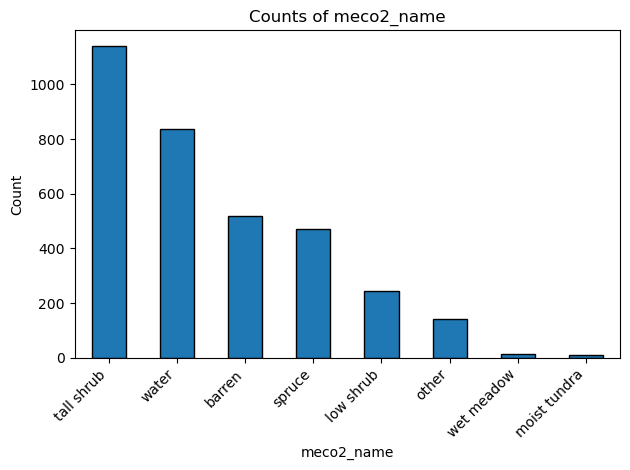

In [7]:
vc = gdf_clean["meco2_name"].value_counts(dropna=False)  # include NaN as a bar
ax = vc.plot(kind="bar", edgecolor="black")
ax.set_xlabel("meco2_name")
ax.set_ylabel("Count")
ax.set_title("Counts of meco2_name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

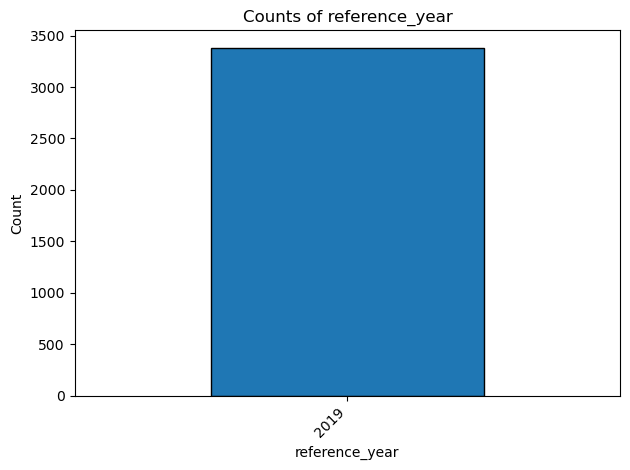

In [8]:
vc = gdf_clean["reference_year"].value_counts(dropna=False)

# sort by the index (the years)
vc = vc.sort_index()

ax = vc.plot(kind="bar", edgecolor="black")
ax.set_xlabel("reference_year")
ax.set_ylabel("Count")
ax.set_title("Counts of reference_year")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

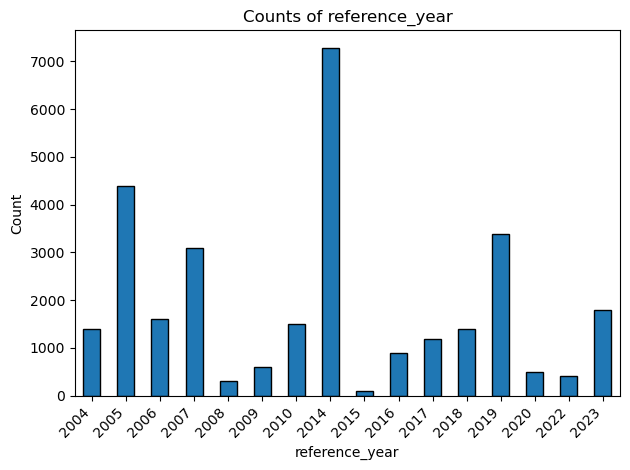

In [9]:
vc = gdf["reference_year"].value_counts(dropna=False)

# sort by the index (the years)
vc = vc.sort_index()

ax = vc.plot(kind="bar", edgecolor="black")
ax.set_xlabel("reference_year")
ax.set_ylabel("Count")
ax.set_title("Counts of reference_year")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
final_map = {
    0: "moist tundra",
    1: "low shrub",
    2: "tall shrub",
    3: "barren",             # match “barren” (reference has no "barrens" plural issue)
    4: "water",              # lake water → water
    5: "water",              # riverine/ocean water → water
    6: "spruce",
    7: "other",              # cloud shadow → other
    8: "other",              # snow → other
    9: "wet meadow",         # marsh/wet meadow → map to wet meadow
}

# Reference (already strings)
ref_map = {
    "low shrub": "low shrub",
    "barren": "barren",
    "tall shrub": "tall shrub",
    "water": "water",
    "other": "other",
    "spruce": "spruce",
    "wet meadow": "wet meadow",
    "moist tundra": "moist tundra",
    "marsh": "wet meadow",   # collapse marsh → wet meadow
}

gdf_clean["ref_class"] = gdf_clean["meco2_name"].map(ref_map)

# Predictions (ints → strings)
gdf_clean["pred_class"] = gdf_clean["lc_val_match"].map(final_map)

In [11]:
gdf.crs

<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meter)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
#import geopandas as gpd
#import xyzservices.providers as xyz

#gdf_clean_gdf = gpd.GeoDataFrame(
#    gdf_clean[['ref_class', 'pred_class', 'geometry']],
#    geometry=gdf_clean["geometry"],
#    crs="EPSG:3338"   # <-- replace with the correct CRS
#)
#type(gdf_clean_gdf)

# Example: first 500 rows
#m = gdf_clean[['ref_class', 'pred_class', 'geometry']].head(500).explore(
#    tiles=xyz.Esri.WorldImagery,   # Esri imagery basemap
#    popup=True,                    # optional: show attributes on click
#)
#m

In [13]:
gdf_clean.head()

,OBJECTID_1,OBJECTID,stn_id,pnt_id,stn_pnt_id,veg_1980,veg_2007,veg_2018_a,conf1980,conf2007,...,Stasis,meco2_name,meco2_date,lc_WV03_20190818_M1BS_1040010051771700-sr-02m,geometry,reference_year,lc_val_2019,lc_val_match,ref_class,pred_class
0,1,1,117408,28.0,117408_028,water,None,low shrub,high,None,...,0.105545,low shrub,2019-06-28,1.0,POINT (100800 1467630),2019,1.0,1.0,low shrub,low shrub
1,2,2,117408,38.0,117408_038,water,None,low shrub,high,None,...,0.105545,low shrub,2019-06-28,1.0,POINT (100830 1467630),2019,1.0,1.0,low shrub,low shrub
2,3,3,117408,49.0,117408_049,water,None,barren,high,None,...,0.105545,barren,2019-06-28,1.0,POINT (100860 1467630),2019,1.0,1.0,barren,low shrub
3,4,4,117408,60.0,117408_060,barren,None,barren,high,None,...,0.105545,barren,2019-06-28,1.0,POINT (100890 1467630),2019,1.0,1.0,barren,low shrub
4,5,5,117408,71.0,117408_071,barren,None,tall shrub,high,None,...,0.105545,tall shrub,2019-06-28,1.0,POINT (100920 1467630),2019,1.0,1.0,tall shrub,low shrub


In [14]:
labels = ['moist tundra','low shrub','tall shrub','barren',
          'water','spruce','other','wet meadow']

label_to_int = {lab:i for i,lab in enumerate(labels)}

gdf_clean["ref_code"] = gdf_clean["ref_class"].map(label_to_int)
gdf_clean["pred_code"] = gdf_clean["pred_class"].map(label_to_int)

In [15]:
gdf_clean.head()

,OBJECTID_1,OBJECTID,stn_id,pnt_id,stn_pnt_id,veg_1980,veg_2007,veg_2018_a,conf1980,conf2007,...,meco2_date,lc_WV03_20190818_M1BS_1040010051771700-sr-02m,geometry,reference_year,lc_val_2019,lc_val_match,ref_class,pred_class,ref_code,pred_code
0,1,1,117408,28.0,117408_028,water,None,low shrub,high,None,...,2019-06-28,1.0,POINT (100800 1467630),2019,1.0,1.0,low shrub,low shrub,1,1
1,2,2,117408,38.0,117408_038,water,None,low shrub,high,None,...,2019-06-28,1.0,POINT (100830 1467630),2019,1.0,1.0,low shrub,low shrub,1,1
2,3,3,117408,49.0,117408_049,water,None,barren,high,None,...,2019-06-28,1.0,POINT (100860 1467630),2019,1.0,1.0,barren,low shrub,3,1
3,4,4,117408,60.0,117408_060,barren,None,barren,high,None,...,2019-06-28,1.0,POINT (100890 1467630),2019,1.0,1.0,barren,low shrub,3,1
4,5,5,117408,71.0,117408_071,barren,None,tall shrub,high,None,...,2019-06-28,1.0,POINT (100920 1467630),2019,1.0,1.0,tall shrub,low shrub,2,1


=== Overall Metrics ===
Accuracy               : 0.0719
Balanced Accuracy      : 0.1250
Precision (weighted)   : 0.0052
Recall (weighted)      : 0.0719
F1 (weighted)          : 0.0096
F1 (macro)             : 0.0168
Cohen's Kappa          : 0.0000
Matthews Corrcoef      : 0.0000

=== Per-class classification report ===
              precision  recall  f1-score   support
moist tundra      0.000   0.000     0.000    12.000
low shrub         0.072   1.000     0.134   243.000
tall shrub        0.000   0.000     0.000  1141.000
barren            0.000   0.000     0.000   519.000
water             0.000   0.000     0.000   838.000
spruce            0.000   0.000     0.000   472.000
other             0.000   0.000     0.000   142.000
wet meadow        0.000   0.000     0.000    15.000
accuracy          0.072   0.072     0.072     0.072
macro avg         0.009   0.125     0.017  3382.000
weighted avg      0.005   0.072     0.010  3382.000


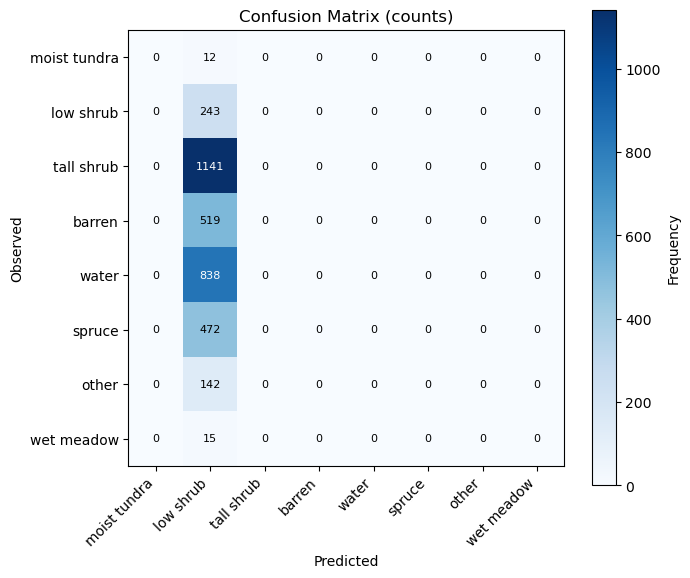

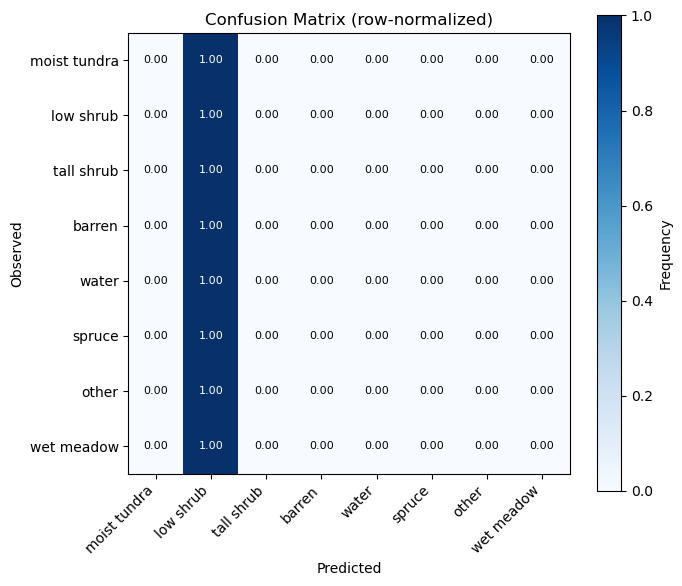


=== Per-class IoU ===
          class    IoU  support
1     low shrub  0.072      243
0  moist tundra  0.000       12
2    tall shrub  0.000     1141
3        barren  0.000      519
4         water  0.000      838
5        spruce  0.000      472
6         other  0.000      142
7    wet meadow  0.000       15
mIoU: 0.0090


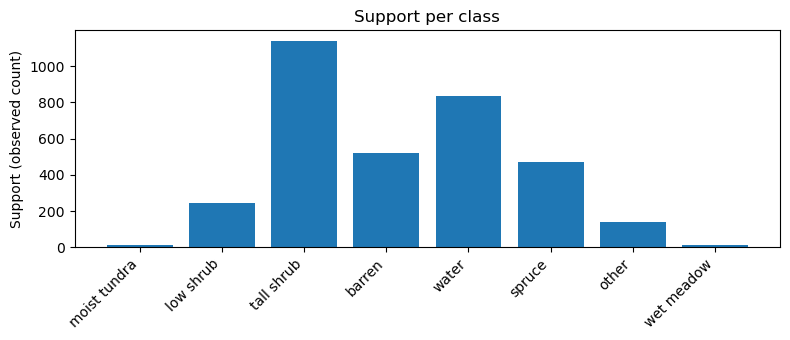

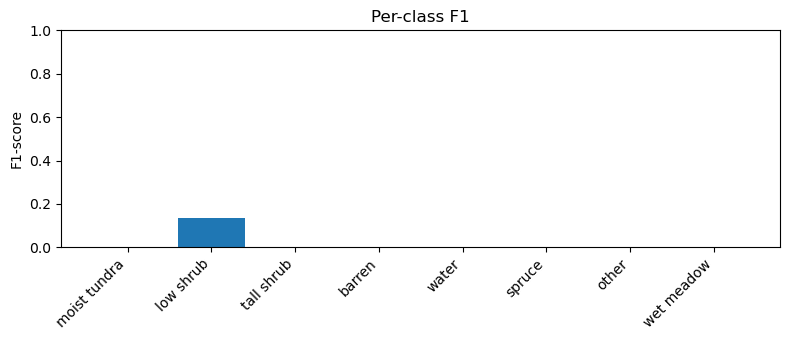

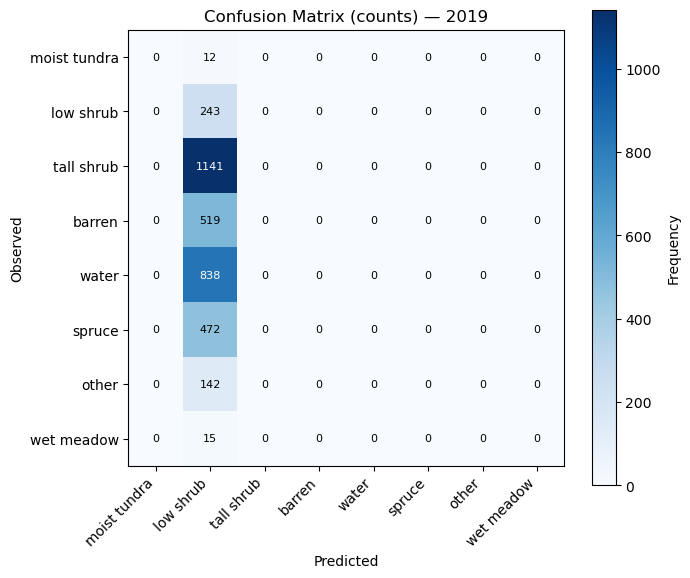

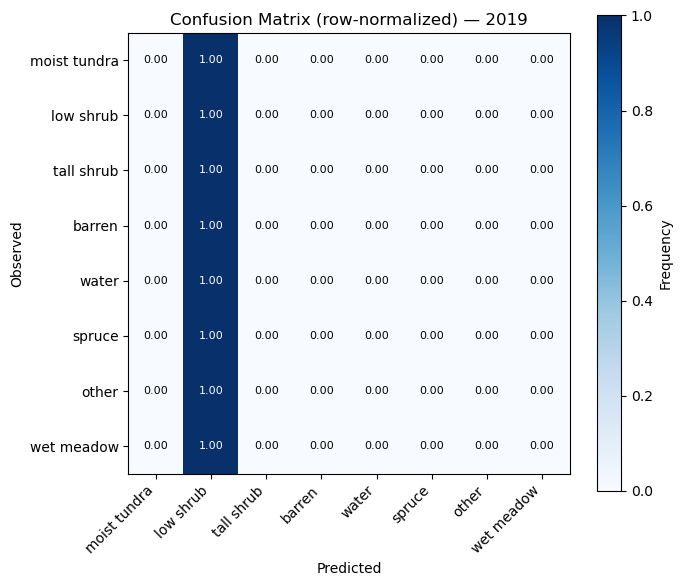


=== Per-year summary ===
   year     n  accuracy  balanced_accuracy  f1_weighted  f1_macro  kappa  mcc  \
0  2019  3382     0.072              0.125         0.01     0.017    0.0  0.0   

    mIoU  
0  0.009  


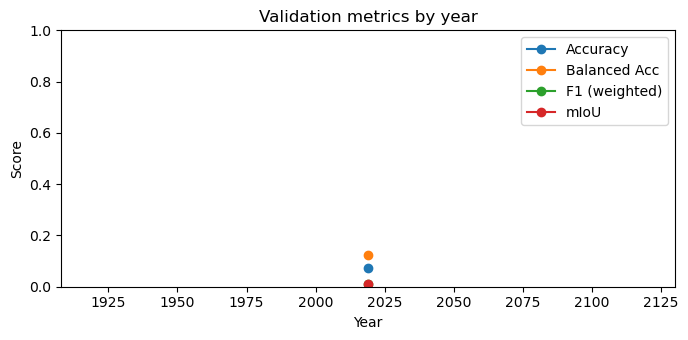


Saved:
  validation_per_class_report.csv
  validation_per_year_summary.csv
  validation_iou_per_class.csv


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, cohen_kappa_score, matthews_corrcoef
)

# ======= CONFIG =======
# If you already enforced these codes earlier, keep this order consistent.
label_names = [
    "moist tundra","low shrub","tall shrub","barren",
    "water","spruce","other","wet meadow"
]
num_classes = len(label_names)
code_to_name = {i: n for i, n in enumerate(label_names)}

# Column names in your GeoDataFrame
COL_TRUE = "ref_code"
COL_PRED = "pred_code"
COL_YEAR = "reference_year"  # adjust if your year column has a different name

# ======= CLEAN DATA =======
df = gdf_clean.copy()
df = df.dropna(subset=[COL_TRUE, COL_PRED]).copy()
df[COL_TRUE] = df[COL_TRUE].astype(int)
df[COL_PRED] = df[COL_PRED].astype(int)

# Optional: ensure year exists when doing per-year metrics
has_year = COL_YEAR in df.columns
if has_year:
    # Coerce to Int64 (nullable) then drop NaNs for per-year calcs
    df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce").astype("Int64")

# ======= OVERALL METRICS =======
y_true = df[COL_TRUE].to_numpy()
y_pred = df[COL_PRED].to_numpy()

acc       = accuracy_score(y_true, y_pred)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
prec_w    = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec_w     = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1_w      = f1_score(y_true, y_pred, average="weighted", zero_division=0)
f1_macro  = f1_score(y_true, y_pred, average="macro", zero_division=0)
kappa     = cohen_kappa_score(y_true, y_pred)
mcc       = matthews_corrcoef(y_true, y_pred)

print("=== Overall Metrics ===")
print(f"Accuracy               : {acc:.4f}")
print(f"Balanced Accuracy      : {bal_acc:.4f}")
print(f"Precision (weighted)   : {prec_w:.4f}")
print(f"Recall (weighted)      : {rec_w:.4f}")
print(f"F1 (weighted)          : {f1_w:.4f}")
print(f"F1 (macro)             : {f1_macro:.4f}")
print(f"Cohen's Kappa          : {kappa:.4f}")
print(f"Matthews Corrcoef      : {mcc:.4f}")

# Classification report (per-class)
report_dict = classification_report(
    y_true, y_pred, labels=range(num_classes),
    target_names=label_names, zero_division=0, output_dict=True
)
report_df = pd.DataFrame(report_dict).T
print("\n=== Per-class classification report ===")
print(report_df.round(3))

# ======= CONFUSION MATRIX (OVERALL) =======
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
# Row-normalized (per observed class)
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, title, labels, cmap="Blues", normalize=False):
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Frequency" if not normalize else "Proportion")

    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels, yticklabels=labels,
        ylabel="Observed", xlabel="Predicted",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Annotate each cell
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            text_val = f"{cm[i, j]:.2f}" if cm.dtype.kind == 'f' else f"{cm[i, j]:d}"
            ax.text(j, i, text_val,
                    ha="center", va="center", color=color, fontsize=8)

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, "Confusion Matrix (counts)", label_names)
plot_confusion_matrix(cm_norm, "Confusion Matrix (row-normalized)", label_names)

# ======= PER-CLASS IoU & mIoU =======
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
IoU = TP / np.clip(TP + FP + FN, 1, None)
mIoU = np.nanmean(IoU)

iou_df = pd.DataFrame({
    "class": label_names,
    "IoU": IoU,
    "support": cm.sum(axis=1)
}).sort_values("IoU", ascending=False)

print("\n=== Per-class IoU ===")
print(iou_df.round(3))
print(f"mIoU: {mIoU:.4f}")

# Quick visuals: support and per-class F1
support_per_class = cm.sum(axis=1)
f1_per_class = report_df.loc[label_names, "f1-score"].values

fig, ax = plt.subplots(figsize=(8,3.5))
ax.bar(label_names, support_per_class)
ax.set_ylabel("Support (observed count)")
ax.set_title("Support per class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8,3.5))
ax.bar(label_names, f1_per_class)
ax.set_ylabel("F1-score")
ax.set_title("Per-class F1")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ======= PER-YEAR METRICS (if year column available) =======
if has_year:
    yearly_rows = []
    years = df[COL_YEAR].dropna().unique().tolist()
    years = sorted([int(y) for y in years])
    for y in years:
        sub = df[df[COL_YEAR] == y]
        if sub.empty:
            continue
        yt = sub[COL_TRUE].to_numpy(dtype=int)
        yp = sub[COL_PRED].to_numpy(dtype=int)

        cm_y = confusion_matrix(yt, yp, labels=range(num_classes))
        acc_y      = accuracy_score(yt, yp)
        balacc_y   = balanced_accuracy_score(yt, yp)
        f1w_y      = f1_score(yt, yp, average="weighted", zero_division=0)
        f1m_y      = f1_score(yt, yp, average="macro", zero_division=0)
        kappa_y    = cohen_kappa_score(yt, yp)
        mcc_y      = matthews_corrcoef(yt, yp)

        # IoU per year
        TP_y = np.diag(cm_y)
        FP_y = cm_y.sum(axis=0) - TP_y
        FN_y = cm_y.sum(axis=1) - TP_y
        IoU_y = TP_y / np.clip(TP_y + FP_y + FN_y, 1, None)
        mIoU_y = np.nanmean(IoU_y)

        yearly_rows.append({
            "year": y,
            "n": len(sub),
            "accuracy": acc_y,
            "balanced_accuracy": balacc_y,
            "f1_weighted": f1w_y,
            "f1_macro": f1m_y,
            "kappa": kappa_y,
            "mcc": mcc_y,
            "mIoU": mIoU_y,
        })

        # OPTIONAL: small confusion matrix plot per year
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_y_norm = cm_y / cm_y.sum(axis=1, keepdims=True)
            cm_y_norm = np.nan_to_num(cm_y_norm)
        plot_confusion_matrix(cm_y, f"Confusion Matrix (counts) — {y}", label_names)
        plot_confusion_matrix(cm_y_norm, f"Confusion Matrix (row-normalized) — {y}", label_names)

    yearly_df = pd.DataFrame(yearly_rows).sort_values("year")
    print("\n=== Per-year summary ===")
    print(yearly_df.round(3))

    # Trend plots
    fig, ax = plt.subplots(figsize=(7,3.5))
    ax.plot(yearly_df["year"], yearly_df["accuracy"], marker="o", label="Accuracy")
    ax.plot(yearly_df["year"], yearly_df["balanced_accuracy"], marker="o", label="Balanced Acc")
    ax.plot(yearly_df["year"], yearly_df["f1_weighted"], marker="o", label="F1 (weighted)")
    ax.plot(yearly_df["year"], yearly_df["mIoU"], marker="o", label="mIoU")
    ax.set_xlabel("Year"); ax.set_ylabel("Score"); ax.set_ylim(0,1)
    ax.set_title("Validation metrics by year")
    ax.legend()
    plt.tight_layout()
    plt.show()

# ======= OPTIONAL: SAVE TABLES =======
report_df.to_csv("validation_per_class_report.csv")
if has_year:
    yearly_df.to_csv("validation_per_year_summary.csv")
iou_df.to_csv("validation_iou_per_class.csv")

print("\nSaved:")
print("  validation_per_class_report.csv")
if has_year:
    print("  validation_per_year_summary.csv")
print("  validation_iou_per_class.csv")
